In [30]:
#run me first!
#click here and press ctrl-enter

from desyncedcompiler import *

# Introduction to Python to Desynced Compiler 

In this project, we aim to develop a Python to Desynced compiler. Desynced is a video game that comes with its own visual programming language:  
https://www.desyncedgame.com/  
The goal for this project was for me to learn how to compile from an Abstract Syntax Tree.  I hope you find it useful for either playing Desynced or for writing your own compilers!  This was my first ever compiler, so feedback is warmly welcomed!

# Using this Workbook
Each step is divided in two parts - the code to accomplish the step, and a separate block to demonstrate it.  Be sure to execute all cells above the step you're interested in, and modify experimental code cell to see how the associated transform works.

## Steps Involved  
### 1. Generate an Abstract Syntax Tree (AST) from Python
### 2. Replace +-*/ with Function calls Add, Subtract, etc.
### 3.  Translate function calls to a generic "Desynced Call"   
### 4. Flatten Nested Calls 
### 5. Label Variables and Frames
### 6. Flow Control
### 7. Parse Desynced Operations from Instructions File 
### 8. Translate to a Desynced Object (DSO)
### 9. Package the DSO in Base62 Format


## 1. Generate an Abstract Syntax Tree (AST)

The Abstract Syntax Tree (AST) is one of the steps in the usual (python) compilation process.  
Starting with the AST let's us skip tokenizing (lexing), syntax analysis (parsing), and some aspects of semantic analysis (rules checking), and start immediately with a structure we can analyze and manipulate programmatically.

Feel free to try AST parsing any python code you'd like - either define a function and reference it (example 1) or put it in a string and pass it directly (example 2).  
It is worth spending some time getting comfortable at this step.

If this step fails, check that you ran the very first cell in the notebook first!

AST Tree from inspected source:


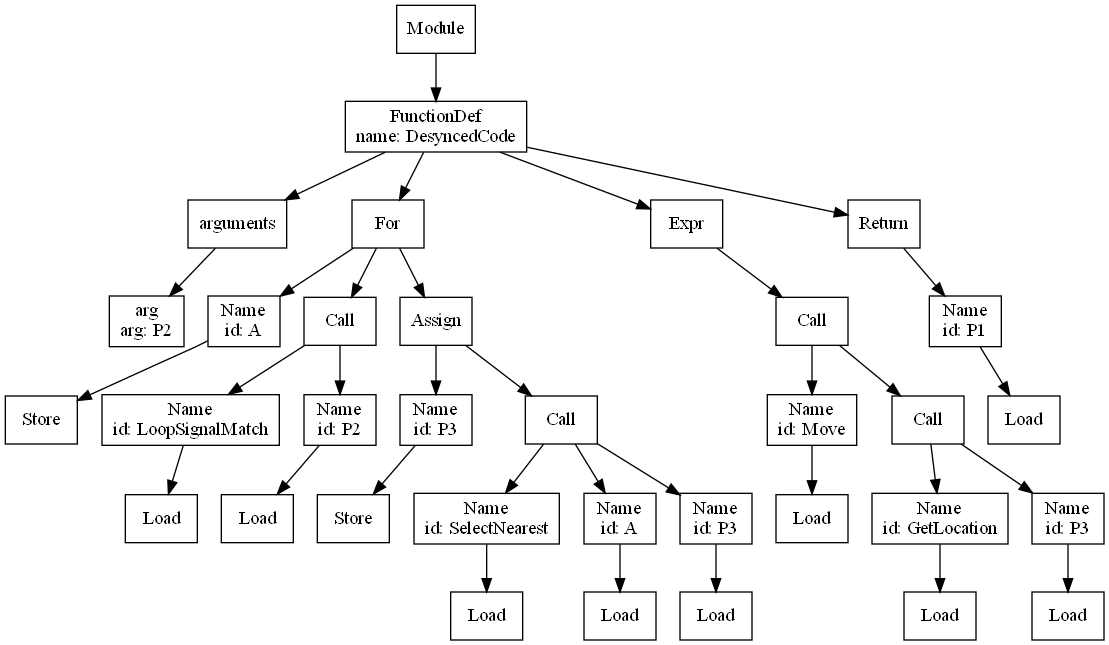

Module(
    body=[
        FunctionDef(
            name='DesyncedCode',
            args=arguments(
                posonlyargs=[],
                args=[arg(arg='P2', annotation=None, type_comment=None)],
                vararg=None,
                kwonlyargs=[],
                kw_defaults=[],
                kwarg=None,
                defaults=[],
            ),
            body=[
                For(
                    target=Name(id='A', ctx=Store()),
                    iter=Call(
                        func=Name(id='LoopSignalMatch', ctx=Load()),
                        args=[Name(id='P2', ctx=Load())],
                        keywords=[],
                    ),
                    body=[
                        Assign(
                            targets=[Name(id='P3', ctx=Store())],
                            value=Call(
                                func=Name(id='SelectNearest', ctx=Load()),
                                args=[
                                    Na

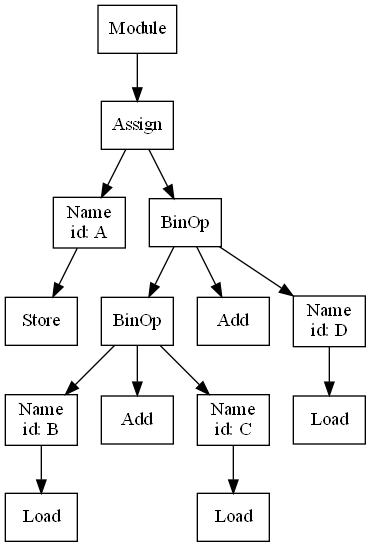

Module(
    body=[
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=BinOp(
                left=BinOp(
                    left=Name(id='B', ctx=Load()),
                    op=Add(),
                    right=Name(id='C', ctx=Load()),
                ),
                op=Add(),
                right=Name(id='D', ctx=Load()),
            ),
            type_comment=None,
        ),
    ],
    type_ignores=[],
)


In [39]:
def DesyncedCode(P2):
    for A in LoopSignalMatch(P2):
        P3 = SelectNearest(A, P3)
    Move(GetLocation(P3))
    return P1

source_code = inspect.getsource(DesyncedCode)
tree = ast.parse(source_code, type_comments=False)
print("AST Tree from inspected source:")
astprint(tree)

source_code_by_string="""
A=B+C+D
"""
tree = ast.parse(source_code_by_string, type_comments=False)
print("\n\nAST Tree from string source:")
astprint(tree)


## 2. Replace +-*/ with Function calls Add, Subtract, etc.

Python supports so many different ways to express things, this step narrows that down a bit.  
BinOps like A+B get replaced with Calls like Add(A,B).  
This is done early so that all function calls in the AST use the same syntax, which makes the rest of the code easier.

The BinOpReplacementVisitor is a NodeTransformer - it walks the AST and calls visit_BinOp on any BinOp nodes, and visit_AugAssign on any AugAssign nodes.  Those nodes are replaced by whatever is returned from those calls.

Try experimenting with order of operations and see if the resulting tree makes sense.

In [24]:
# %load -s replace_binops_with_functions desyncedcompiler.py
def replace_binops_with_functions(tree):
    class BinOpReplacementVisitor(ast.NodeTransformer):
        # Replace binary operations with function calls
        binop_map = {ast.Add: 'Add',
                     ast.Sub: 'Subtract',
                     ast.Mult:'Multiply',
                     ast.Div: 'Divide',
                     ast.Mod: 'Modulo',
                        }
        def visit_BinOp(self, node):
            if isinstance(node.op, ast.operator) and node.op.__class__ in self.binop_map:
                #self.generic_visit(node)
                new_node = ast.Call(
                    func=ast.Name(id=self.binop_map[type(node.op)], ctx=ast.Load()),
                    args=[node.left, node.right],
                    keywords=[],
                    starargs=None,
                    kwargs=None
                )
                new_node=self.visit(new_node)
                return new_node
            else:
                return node

        def visit_AugAssign(self, node):
            if isinstance(node.op, ast.operator) and node.op.__class__ in self.binop_map:
                new_node = ast.Assign(
                    targets = [node.target],
                    value = ast.Call(
                        func=ast.Name(id=self.binop_map[type(node.op)], ctx=ast.Load()),
                        args=[node.target, node.value],
                        keywords=[],
                        starargs=None,
                        kwargs=None
                    )
                )
                
                new_node=self.visit(new_node)
                return new_node
            else:
                return node

    visitor=BinOpReplacementVisitor()
    return visitor.visit(tree)



AST Tree before processing:


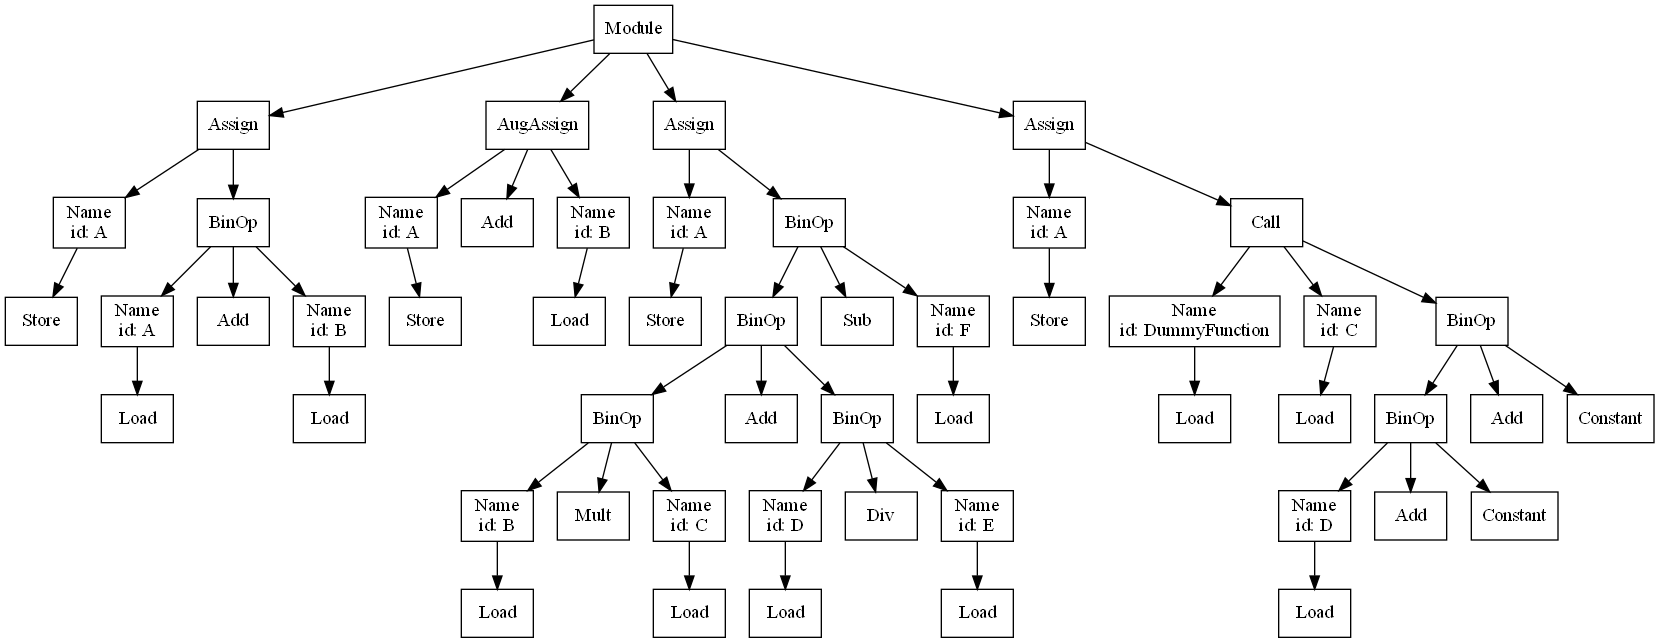

Module(
    body=[
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=BinOp(
                left=Name(id='A', ctx=Load()),
                op=Add(),
                right=Name(id='B', ctx=Load()),
            ),
            type_comment=None,
        ),
        AugAssign(
            target=Name(id='A', ctx=Store()),
            op=Add(),
            value=Name(id='B', ctx=Load()),
        ),
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=BinOp(
                left=BinOp(
                    left=BinOp(
                        left=Name(id='B', ctx=Load()),
                        op=Mult(),
                        right=Name(id='C', ctx=Load()),
                    ),
                    op=Add(),
                    right=BinOp(
                        left=Name(id='D', ctx=Load()),
                        op=Div(),
                        right=Name(id='E', ctx=Load()),
                    ),
                ),
  

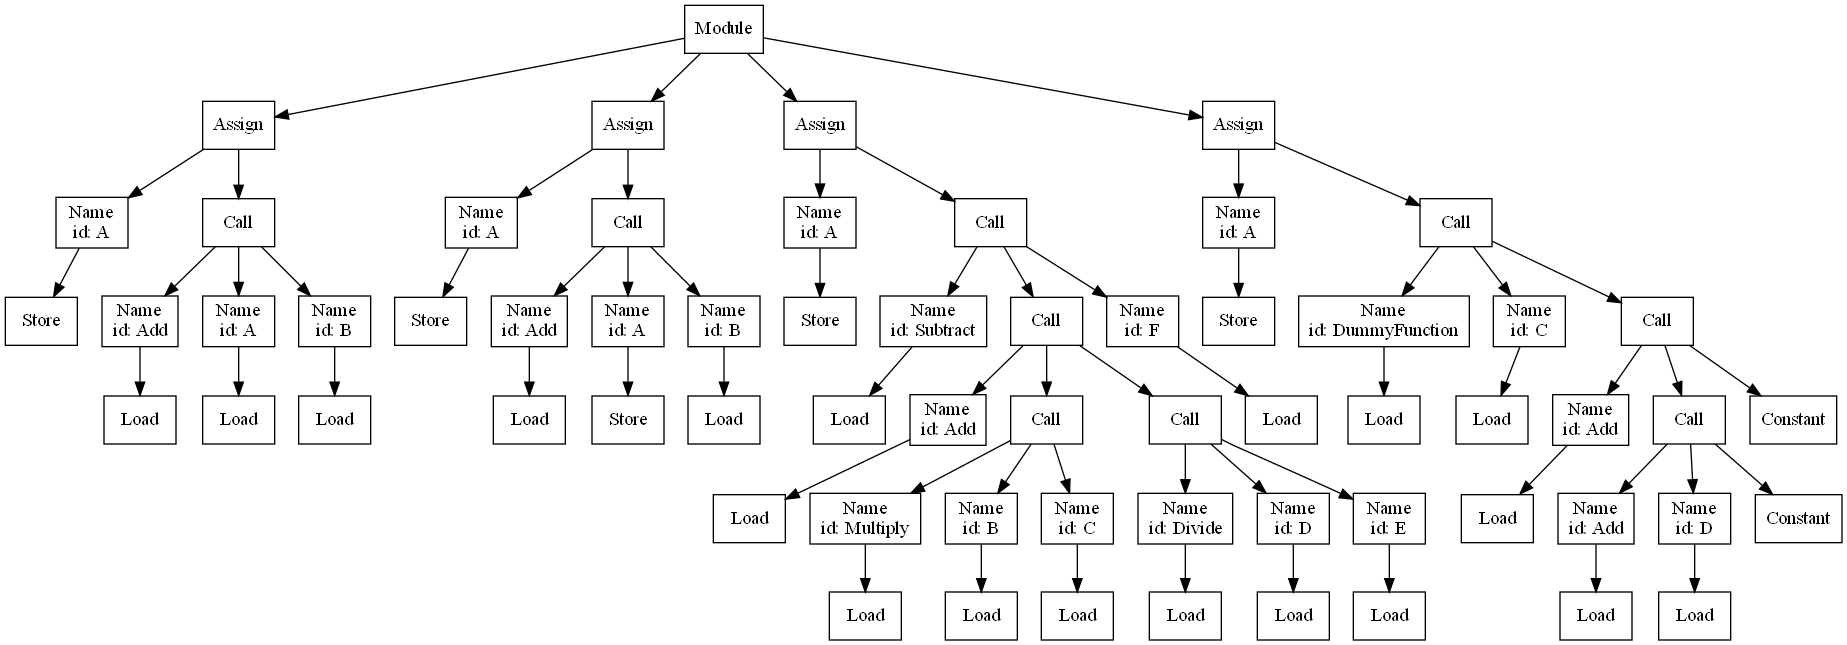

Module(
    body=[
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=Call(
                func=Name(id='Add', ctx=Load()),
                args=[
                    Name(id='A', ctx=Load()),
                    Name(id='B', ctx=Load()),
                ],
                keywords=[],
            ),
            type_comment=None,
        ),
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=Call(
                func=Name(id='Add', ctx=Load()),
                args=[
                    Name(id='A', ctx=Store()),
                    Name(id='B', ctx=Load()),
                ],
                keywords=[],
            ),
            type_comment=None,
        ),
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=Call(
                func=Name(id='Subtract', ctx=Load()),
                args=[
                    Call(
                        func=Name(id='Add', ctx=Load()),
               

In [40]:
source_code='''
A=A+B                        # Typical Binary Operation
A+=B                         # Augmented Assignment
A=B*C+D/E-F                  # Test order of operations
A=DummyFunction(C,D+1+3)     # Test inside of Func Args
'''

tree = ast.parse(source_code, type_comments=False)
print("AST Tree before processing:")
astprint(tree)

print('\n\n')
print("ASTree after replacing binary ops")
tree = replace_binops_with_functions(tree)
astprint(tree)

# 3.  Translate function calls to a generic "Desynced Call"   
Defining a custom AST node type allows us to decorate it with additional information that will later be useful for compilation.  
Specifically, each DS Function containsan *opcode*, *inputs*, *outputs*, and *execution flows*.  
Python's AST includes the inputs as part of the call node, but outputs are held in an Assign node and execution flow is handled fundamentally different.  


# 4. Flatten Nested Calls 
Desynced's execution environment can only handle variables and constants as arguments to a function:  f(g(x)) is outside it's capabilities.  
This step flattens code using temporary variables:  
```python  
A = Distance()
   -->
temp1 = GetClosestEntity("Enemy")
A     = Distance(temp1)
```

3 and 4 happen in the same transformer here

In [50]:
# %load -s DS_Call,transform_nested_calls desyncedcompiler.py
class DS_Call(ast.Assign):
    _fields = ('targets', 'args', 'op', 'frame', 'next')

    def __init__(self, targets, args, op):
        self.targets = targets
        self.args = args
        self.next = {}
        self.frame = -1
        self.op = op

def transform_nested_calls(tree):
    class FlatteningTransformer(ast.NodeTransformer):  
        def __init__(self):
            super().__init__()
            self.temp_count = 1
            
        def visit_Call(self, node, target=None):
            if target:
                node.targets=[target]
            
            nodelist = [DS_Call( targets=[target], args=node.args, op=node.func.id)]
            for i, arg in enumerate(node.args):
                
                if isinstance(arg, ast.Call):
                    temp_var = f'Temp_{self.temp_count}'
                    self.temp_count += 1                    
                    nodelist.insert(0, self.visit_Call(arg, ast.Name(id=temp_var, ctx=ast.Store())))
                    node.args[i] = ast.Name(id=temp_var, ctx=ast.Load())
                    
            # Return a list containing the original call node and the new call node
            def flatten(lst):
                return [item for sublist in lst for item in (flatten(sublist) if isinstance(sublist, list) else [sublist])]
            nodelist = flatten(nodelist)
            for node in nodelist:
                self.visit(node)
            return nodelist

        def visit_Assign(self, node):

            if isinstance(node.value, (ast.Name, ast.Constant, ast.Tuple)):
                
                # Special case for a bare Assignment - this is a Copy function, which is 'set_reg' internally
                new_node = DS_Call(targets = node.targets, args = [node.value], op = 'Copy')
                new_node = self.visit(new_node)
                return new_node
            nodelist = self.visit_Call(node.value)
            nodelist[-1].targets = node.targets
            for n in nodelist:
                self.visit(n)
            return nodelist

        def visit_Expr(self, node):
            nodelist = self.visit_Call(node.value)
            for n in nodelist:
                self.visit(n)
            return nodelist

        def visit_Tuple(self, node):
            if isinstance(node.elts[0], ast.Name):
                return [e for e in node.elts]
            if isinstance(node.elts[0], ast.Constant):
                return ast.Constant( value=[e.value for e in node.elts])
            return node

    return FlatteningTransformer().visit(tree)


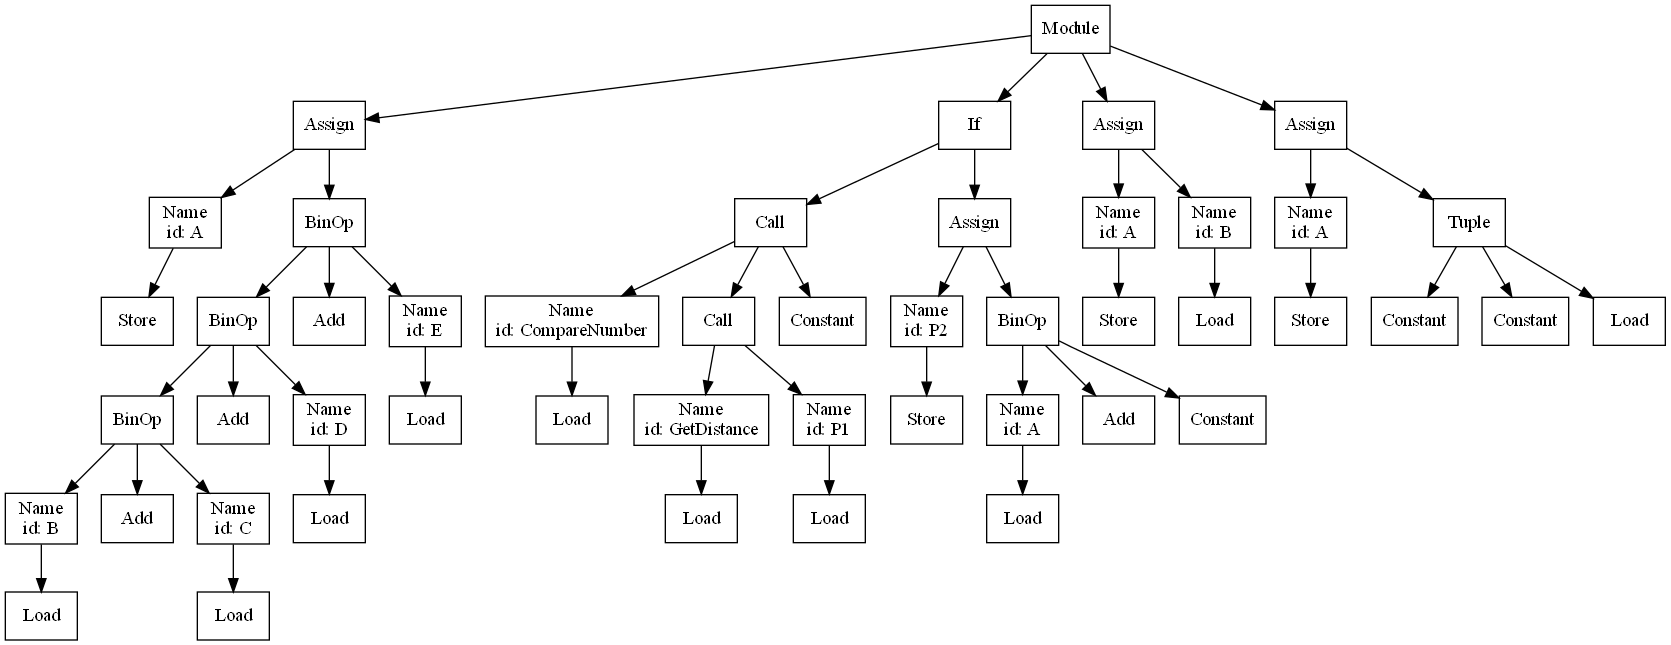

Module(
    body=[
        Assign(
            targets=[Name(id='A', ctx=Store())],
            value=BinOp(
                left=BinOp(
                    left=BinOp(
                        left=Name(id='B', ctx=Load()),
                        op=Add(),
                        right=Name(id='C', ctx=Load()),
                    ),
                    op=Add(),
                    right=Name(id='D', ctx=Load()),
                ),
                op=Add(),
                right=Name(id='E', ctx=Load()),
            ),
            type_comment=None,
        ),
        If(
            test=Call(
                func=Name(id='CompareNumber', ctx=Load()),
                args=[
                    Call(
                        func=Name(id='GetDistance', ctx=Load()),
                        args=[Name(id='P1', ctx=Load())],
                        keywords=[],
                    ),
                    Constant(value=3, kind=None),
                ],
                keywords=[],
       

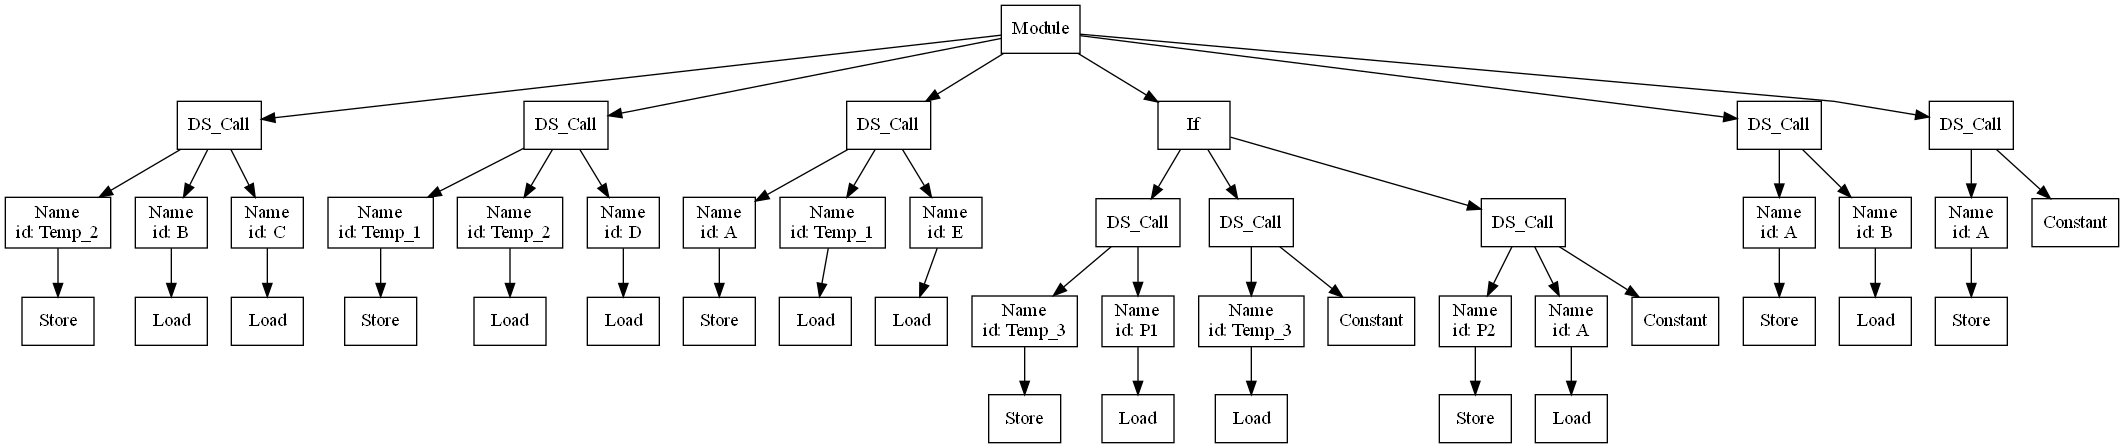

Module(
    body=[
        DS_Call(
            targets=[Name(id='Temp_2', ctx=Store())],
            args=[
                Name(id='B', ctx=Load()),
                Name(id='C', ctx=Load()),
            ],
            op='Add',
            frame=-1,
            next=-1,
        ),
        DS_Call(
            targets=[Name(id='Temp_1', ctx=Store())],
            args=[
                Name(id='Temp_2', ctx=Load()),
                Name(id='D', ctx=Load()),
            ],
            op='Add',
            frame=-1,
            next=-1,
        ),
        DS_Call(
            targets=[Name(id='A', ctx=Store())],
            args=[
                Name(id='Temp_1', ctx=Load()),
                Name(id='E', ctx=Load()),
            ],
            op='Add',
            frame=-1,
            next=-1,
        ),
        If(
            test=[
                DS_Call(
                    targets=[Name(id='Temp_3', ctx=Store())],
                    args=[Name(id='P1', ctx=Load())],
         

In [43]:
source_code='''
# Test nested math
A = B+C+D+E
# Test within a flow statement
if CompareNumber(GetDistance(P1), 3):
    P2 = A+1
# Bare assignment
A=B
# Tuple assignment
A=("metalore", 3)
'''

tree = ast.parse(source_code, type_comments=False)
astprint(tree)
print('\n\n')
tree = replace_binops_with_functions(tree)
tree = transform_nested_calls(tree)
astprint(tree)

# 6. Label Variables and Frames

Temporary variables are renamed.  
All DS_Calls are assigned a frame number, which is the desynced equivalent of a line number.

This is accomplished by first enumerating all of the known variables in the code (VariableFinder).  Then find the lowest unused local variable, and remap temporary variables starting there.  I don't do any form of variable lifespan checking - This is inefficient but usable.  

Then we use another NodeTransformer to visit every DS_Call and give it a frame id number.  Fortunately the NodeTransformer walks the tree in a reasonable manner, which makes it easier to visually inspect later.  This could work with pseudorandom assignment, but this way is cleaner.


In [48]:
# %load -s label_frames desyncedcompiler.py
def label_frames(tree):
    def create_variable_remap(input_list):
        highest_letter = 'A'
        highest_temp_number = 0
    
        for item in input_list:
            if item.startswith('Temp_'):
                temp_number = int(item.split('_')[1])
                highest_temp_number = max(highest_temp_number, temp_number)
            elif item.isalpha():
                highest_letter = max(highest_letter, item)

        mapping = {i:i for i in input_list}
        for i in range(1, highest_temp_number + 1):
            temp_key = f'Temp_{i}'
            temp_value = chr(ord(highest_letter) + i)
            mapping[temp_key] = temp_value
    
        return mapping

    class VariableFinder(ast.NodeVisitor):
        def __init__(self):
            self.variables = {}

        def visit_Name(self, node):
            self.variables[node.id]=None

    class VariableLabeler(ast.NodeTransformer):
        def __init__(self, mapper):
            super().__init__()
            self.mapper = mapper
        
        def visit_Name(self, node):
            if node.id in self.mapper.keys():
                node.id = self.mapper[node.id]
            return node
            
    class FrameLabeler(ast.NodeTransformer):  
        def __init__(self):
            super().__init__()
            self.frame_count = 0
            
        def visit_DS_Call(self, node):
            node.frame = self.frame_count
            self.frame_count+=1
            return node

            
    finder = VariableFinder()
    finder.visit(tree)
    vars = finder.variables.keys()
    remap = create_variable_remap(vars)
    varlabeler = VariableLabeler(remap)
    tree = varlabeler.visit(tree)
    framelabeler = FrameLabeler()
    tree = framelabeler.visit(tree)
    return tree


In [63]:
source_code='''
A=B
A=A+1
A = B+C+D+E
if CompareNumber(GetDistance(P1), 3):
    P2 = A+1
'''


tree = ast.parse(source_code, type_comments=False)

tree = replace_binops_with_functions(tree)
tree = transform_nested_calls(tree)
astprint(tree)
print('\n\n')
tree = label_frames(tree)
astprint(tree)

Module(
    body=[
        DS_Call(
            targets=[Name(id='A', ctx=Store())],
            args=[Name(id='B', ctx=Load())],
            op='Copy',
            frame=-1,
            next={},
        ),
        DS_Call(
            targets=[Name(id='A', ctx=Store())],
            args=[
                Name(id='A', ctx=Load()),
                Constant(value=1, kind=None),
            ],
            op='Add',
            frame=-1,
            next={},
        ),
        DS_Call(
            targets=[Name(id='Temp_2', ctx=Store())],
            args=[
                Name(id='B', ctx=Load()),
                Name(id='C', ctx=Load()),
            ],
            op='Add',
            frame=-1,
            next={},
        ),
        DS_Call(
            targets=[Name(id='Temp_1', ctx=Store())],
            args=[
                Name(id='Temp_2', ctx=Load()),
                Name(id='D', ctx=Load()),
            ],
            op='Add',
            frame=-1,
            next={},
     

# 7. Flow Control

Flow control dictates the order in which these ops are called.  The linear sections are easy - just link each frame to the next one.
The first and last frame in a sequence are special.  The first frame is where other sequences link into a sequence, the last frame is where it links out.  
The helper function makes it easier to identify these special frames, and then each of the flow control elements (IF, While, For) have to be special cased.

I don't use a Transformer class here so that I have better access to the parents of a node that is being visited.

In [64]:
# %load -s flow_control desyncedcompiler.py
def flow_control(tree):

    def find_first_last_DS_Call(list):
        class DSFinder(ast.NodeVisitor):
            def __init__(self):
                self.last=None
                self.first= None
    
            def visit_DS_Call(self, node):
    
                self.last = node
                if self.first is None:
                    self.first = node
    
        finder = DSFinder()
        for tree in list:
            finder.visit(tree)
        return finder.first, finder.last
    
    def flow_list(nodelist, exit=-1):
        #myexit = find_first_last_DS_Call(nodelist)
        for item, next_item in zip(nodelist, nodelist[1:] + [None]):
            lexit = exit if next_item is None else find_first_last_DS_Call([next_item])[0].frame
            if isinstance(item, DS_Call):
                item.next = {'next': lexit}
            if isinstance(item, ast.While):
                flow_While(item, lexit)
            if isinstance(item, ast.If):
                flow_If(item, lexit)
            if isinstance(item, ast.For):
                flow_For(item, lexit)
    
    def flow_While(node, exit=-1):
        flow_list(node.test)
        flow_list(node.body)
        body_first, body_last = find_first_last_DS_Call(node.body)
        test_first, test_last = find_first_last_DS_Call(node.test)
    
        test_last.next = {'next': body_first.frame, 'exit': exit}
        body_last.next = {'next': test_first.frame,}
    
    def flow_If(node, exit=-1):
        flow_list(node.test)
        flow_list(node.body)
        flow_list(node.orelse)
        body_first, body_last = find_first_last_DS_Call(node.body)
        test_first, test_last = find_first_last_DS_Call(node.test)
        orelse_first, orelse_last = find_first_last_DS_Call(node.orelse)
    
        test_last.next = {'next': exit if body_first is None else body_first.frame,
                          'else': exit if orelse_first is None else orelse_first.frame}
        if body_last:
            body_last.next = {'next': exit}
        if orelse_last:
            orelse_last.next = {'next':exit}
    
    
    def flow_For(node, exit=-1):
        target = node.target
        node.target = None
        #print('For:')
        #astprint(node)
        flow_list(node.body)
        flow_list(node.iter)
        body_first, body_last = find_first_last_DS_Call(node.body)
        iter_first, iter_last = find_first_last_DS_Call(node.iter)
    
        iter_last.next = {'next': body_first.frame, 
                          'exit': exit}
        body_last.next= {'next': False}
        if isinstance(target, list):
            iter_last.targets = target
        else:
            iter_last.targets = [target]
            
    # this is a real bad hack and will need to be fixed to support nested function calls.
    if isinstance(tree.body[0], ast.FunctionDef):
        return flow_list(tree.body[0].body)
    return flow_list(tree.body)


In [65]:
source_code='''

while CheckBattery(GetSelf()):
    B=B+1
    A=1+2+3
for C in LoopSignalMatch(P3):
   P4=("Ore", 17)
'''


tree = ast.parse(source_code, type_comments=False)

tree = replace_binops_with_functions(tree)
tree = transform_nested_calls(tree)
tree = label_frames(tree)
#astprint(tree)
#print('\n\n')
flow_control(tree)
astprint(tree)

Module(
    body=[
        While(
            test=[
                DS_Call(
                    targets=[Name(id='D', ctx=Store())],
                    args=[],
                    op='GetSelf',
                    frame=0,
                    next={'next': 1},
                ),
                DS_Call(
                    targets=[
                        None,
                    ],
                    args=[Name(id='D', ctx=Load())],
                    op='CheckBattery',
                    frame=1,
                    next={'next': 2, 'exit': 5},
                ),
            ],
            body=[
                DS_Call(
                    targets=[Name(id='B', ctx=Store())],
                    args=[
                        Name(id='B', ctx=Load()),
                        Constant(value=1, kind=None),
                    ],
                    op='Add',
                    frame=2,
                    next={'next': 3},
                ),
                DS_Call(
        

# 7. Parsing Desynced Operations from Instructions File 
Desynced  has its set of operations and functions that it understands.  Rather than type them all in by hand, parse them out of one of the game files, "instructions.lua".  This is done with "exportinstructions.lua".  I'm not going to include the original file; that belongs to Stage Games Inc.  However, I have been given permission to include the parsed output, "instructions.json"

Whenever new ops are added instructions.json will need to be updated.  Simply put "instructions.lua" next to "exportinstructions.lua" and run lua exportinstructions.lua.  Note that the functions get stripped out, so if you encounter any syntax errors (Lua version mismatch?) just delete the offending function... or pull request a more intelligent fix!

Here is the parser, written in lua:  
##### exportinstructions.lua
```lua
data = {}

data.instructions={}
local instructions = require("instructions")
local json = require("dkjson")


-- Filter out function elements
local function filterFunctions(tbl)
    local filteredTable = {}
    for key, value in pairs(tbl) do
        if type(value) == "table" then
            filteredTable[key] = filterFunctions(value)
        elseif type(value) ~= "function" then
            filteredTable[key] = value
        end
    end
    return flteredTable
end


local filteredInstructions = filterFunction(data.instructions)

local jsonStr = json.encode(filteredInstructions, { indent = true })
local file = io.open("instructions.json", "w")
file:write(jsonStr)
file:close()
```

The resulting file looks like this (truncated):  
```json
{
    "check_grid_effeciency":{
        "name":"Check Grid Efficiency",
        "args":[["exec","Full","Where to continue if at full efficiency"],["in","Unit","The unit to check for (if not self)","entity",true]],
        "category":"Unit",
        "icon":"Main/skin/Icons/Common/56x56/Power.png",
        "desc":"Checks the Efficiency of the power grid the unit is on"
    },
    "moveaway_range":{
        "name":"Move Away (Range)",
        "args":[["in","Target","Unit to move away from","entity"]],
        "category":"Move",
        "icon":"Main/skin/Icons/Special/Commands/Move To.png",
        "desc":"Moves out of range of another unit"
    },
        "disconnect":{
        "desc":"Disconnects Units from Logistics Network",
        "icon":"Main/skin/Icons/Common/56x56/Carry.png",
        "name":"Disconnect",
        "category":"Unit"
        },
}
```


In [54]:
# %load -s import_desynced_ops desyncedcompiler.py
def import_desynced_ops(path):
    def to_function_name(string):
        # Desynced block names are typically all capitalized.  Standardize on this.
        # Obsolete instructions are marked by being surrounded by asterixes.  Replace with _ so it is a valid python function name
        result =''.join([word.capitalize() for word in string.replace('*','_').replace('(','').replace(')','').split()])
        return result
        
    with open (path, 'r') as jsonfile:
        raw_import = json.load(jsonfile)
    instructions = {to_function_name(v['name']):{**v, 'op':k} for k,v in raw_import.items() if 'name' in v.keys()}
    return instructions


In [55]:
ds_ops = import_desynced_ops("./instructions.json")

# 8. Translate to a Desynced Object (DSO)

The modified AST tree now has all the information necessary to emit actual op codes.  

Desynced's intermediate langauge visualizes as JSON, but it was not designed for readability.  All descriptive field names are stripped and replaced with numerical indices.  

At the end of this we have something that should be able to be converted by the tool on this webpage:
https://stagegames.github.io/DesyncedJavaScriptUtils/

Note that printing a python dict is slightly different than printing as json string.


In [56]:
# %load -s create_dso_from_ast desyncedcompiler.py
def create_dso_from_ast(tree):

    class DSO_from_DSCalls(ast.NodeVisitor):
        def __init__(self, debug=False):
            self.dso={}
            self.debug=debug
            self.parameters={}

        def translate_register_or_value(self, tlist, ix):
            try:
                val = tlist[ix]
            except IndexError:
                return False
            # Values get Handled here.
            #  '_" is special cased to mean not used.
            #  Local variables (A,B,C) are emitted as strings.
            #  Parameters (P1, P2) are emitted as numbers.
            if isinstance(val, ast.Name):
                if val.id == '_':
                    return False
                if val.id[0] == 'P':
                    parameter_ix = int(val.id[1:])
                    self.parameters[parameter_ix]=True
                    return parameter_ix
                specialregs= {'Goto':-1,
                              'Store':-2,
                              'Visual':-3,
                              'Signal':-4}
                if val.id in specialregs.keys():
                    return specialregs[val.id]
                return val.id
                
            if isinstance(val, ast.Constant):
                if isinstance(val.value, int):
                    return {"num": val.value}
                if isinstance(val.value, str):
                    #this is where to add translation of constants, e.g. "Metal Ore" to "metalore"
                    return {"id": val.value}

                if isinstance(val.value, list):
                    if isinstance(val.value[0], int) and isinstance(val.value[1], int):
                        return {"coord": {"x": val.value[0], "y": val.value[1]} }
                    if isinstance(val.value[0], str) and isinstance(val.value[1], int):
                        return {"id": val.value[0], "num": val.value[1]}
                    if isinstance(val.value[0], int) and isinstance(val.value[1], str):
                        return {"id": val.value[1], "num": val.value[0]}

        def visit_DS_Call(self, node):
            op = ds_ops[node.op]
            if self.debug:
                print('\n\n')
                print(op)
                astprint(node)
            res={}
            res['op'] = op['op']
            if node.next['next'] != node.frame+1:
                res['next'] = node.next['next']
            target_ix=0
            arg_ix=0
            exec_ix=1
            if 'args' in op.keys():
                if self.debug:
                    print(op['args'])
                for i, arg in enumerate(op['args']):
                    if arg[0] == 'out':
                        res[str(i)] = self.translate_register_or_value(node.targets,target_ix)
                        target_ix +=1
                    if arg[0] == 'in':
                        res[str(i)] = self.translate_register_or_value(node.args,arg_ix)
                        arg_ix +=1
                    if arg[0] == 'exec':
                        res[str(i)]=list(node.next.values())[exec_ix]+1
                        exec_ix+=1
                        
            self.dso[str(node.frame)] = res
            if self.debug:
                print(res)

        def parameters_block(self):
            if len(self.parameters):
                pblock = [self.parameters.get(i+1, False) for i in range(max(self.parameters.keys()))]
                self.dso["parameters"] = pblock

        def name_block(self, tree):
            try:
                name = tree.body[0].name
            except:
                name = "FromPythonCompiler"
            self.dso["name"] = name
            
    walker = DSO_from_DSCalls()
    walker.visit(tree)
    walker.parameters_block()
    walker.name_block(tree)
    dso = walker.dso
    
    return walker.dso


Tree before conversion to DSO:


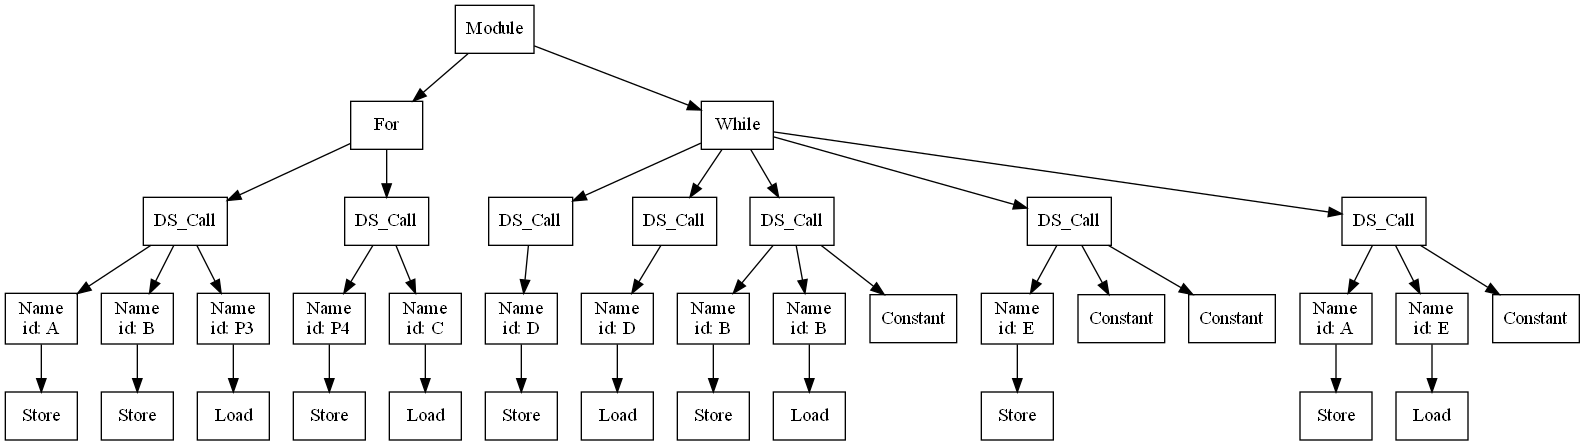

Module(
    body=[
        For(
            target=None,
            iter=[
                DS_Call(
                    targets=[
                        Name(id='A', ctx=Store()),
                        Name(id='B', ctx=Store()),
                    ],
                    args=[Name(id='P3', ctx=Load())],
                    op='LoopSignalMatch',
                    frame=0,
                    next={'next': 1, 'exit': 2},
                ),
            ],
            body=[
                DS_Call(
                    targets=[Name(id='P4', ctx=Store())],
                    args=[Name(id='C', ctx=Load())],
                    op='Copy',
                    frame=1,
                    next={'next': False},
                ),
            ],
            orelse=[],
            type_comment=None,
        ),
        While(
            test=[
                DS_Call(
                    targets=[Name(id='D', ctx=Store())],
                    args=[],
                    op='GetSelf',
 

In [57]:
source_code='''
for A, B in LoopSignalMatch(P3):
    P4=C
    
while CheckBattery(GetSelf()):
    B=B+1
    A=1+2+3
'''


tree = ast.parse(source_code, type_comments=False)
tree = replace_binops_with_functions(tree)
tree = transform_nested_calls(tree)
tree = label_frames(tree)
flow_control(tree)

print("Tree before conversion to DSO:")
astprint(tree)

print("DSO:")
dso = create_dso_from_ast(tree)
print(json.dumps(dso))

# 9. Base62 Encode  
Desynced has it's own variant of the Base62 encoding format that is uses to make these json files easily copy pasted on the internet.  As a last step we shove the JSON into this format so it can be copied into the game.

I haven't quite gotten this ported over, so in the mean time I'm using the converter from this webpage:
https://stagegames.github.io/DesyncedJavaScriptUtils/

This is accomplished by loading their javascript into python with py_mini_racer.  
It isn't fully compatible with py_mini_racer, so I patch in a simple / good enough version of TextEncoder.

In [111]:
# %load -s object_to_desynced_string desyncedcompiler.py
def object_to_desynced_string(obj, dtype="C"):
    # Create a PyMiniRacer instance
    ctx = py_mini_racer.MiniRacer()
    
    # Load the JavaScript file
    with open('dsconvert.js', 'r') as file:
        js_code = file.read()
    patch = '''
    class TextEncoder {
        encode(str) {
            const codeUnits = new Uint8Array(str.length);
            for (let i = 0; i < str.length; i++) {
                codeUnits[i] = str.charCodeAt(i);
            }
            return codeUnits;
        }
    }
    '''
    # Evaluate the JavaScript code
    ctx.eval(patch+js_code)
    
    # Call the JavaScript function
    result = ctx.call('ObjectToDesyncedString', obj,dtype)

    return result


In [62]:
source_code='''
for A, B in LoopSignalMatch(P3):
    P4=C
    
while CheckBattery(GetSelf()):
    B=B+1
    A=1+2+3'''


tree = ast.parse(source_code, type_comments=False)
tree = replace_binops_with_functions(tree)
tree = transform_nested_calls(tree)
tree = label_frames(tree)
flow_control(tree)
dso = create_dso_from_ast(tree)
desyncedstring = object_to_desynced_string(dso)
print(desyncedstring)

DSC7q3mEoMi0tNEYn1pOkng2VpTWE4dS0DL0IhA3d3YFxkA04rhOI478kZP2Wjhri1uPtqK4UtqJb4EVV6o0sN4I71ZMY4W0ivDBy4220XH03UK1e43Iz6F1XEjDn39Bihk3JZN4P0kFBst0Egrjm40Va1J4DjyDA1TP6Sl1YdgGk11vrnT2NZs9f4cibp51a7xkH2ufyXf472PX340faYh3eeh1p1ErVyH1AKxqI43Rj5l0Rc1wc1drHwf1uxpVA1RNmaf3FrtSV0lsvKZ2Q7Tpq752Z


# Putting it all together

At this point we have a working Python to Desynced compiler!
... with a very, very long to do list.

Wrap the whole thing in a function and try some example code:

In [61]:
# %load -s python_to_desynced desyncedcompiler.py
def python_to_desynced(code):
    if callable(code):
        code = inspect.getsource(code)
    tree = ast.parse(code, type_comments=False)

    tree = replace_binops_with_functions(tree)
    tree = transform_nested_calls(tree)
    tree = label_frames(tree)
    flow_control(tree)
    dso = create_dso_from_ast(tree)
    desyncedstring = object_to_desynced_string(dso)
    return desyncedstring


In [60]:
def DistanceToEnemy():
    P1 = GetClosestEntity("v_enemy_faction")
    P2 = Distance(P1)
    
dstring = python_to_desynced(DistanceToEnemy)
print(dstring)

DSC4X3kxcHQ0tML8z3x72jA16LRfm4bYwWa07As4W2OyHgS2NI4k42VxlNX4Gabce20uRcX2YgrMd23IZsx4O48tg3q7wf84VgIWq3mCdqU1wgXH30BO6Fo14kUR84MNzOw2vRi9h3JXYYM3VucAE2CxymH3TZt8z1MKuAn4aPAwN2j1xmZ3XNFxL0tOQSg40P


In [59]:
def SmartRecycler():
    WaitTicks(5)
    for A,_ in LoopEntitiesRange(10, "v_construction"):
        for B in LoopRecipeIngredients(A):
            OrderTransferTo(A,B)
    OrderToSharedStorage()
    if CheckSpaceForItem("c_radio_receiver"):
        Signal = "v_color_green"
    else:
        Signal = _

dstring = python_to_desynced(SmartRecycler)
print(dstring)

DSCAr2cqh9U0tMgiz1UHhTc2yo0hm0jjO6R2Fqvrz4KQ5Mw3E22nI0kiMIF1nVQTh0qk4H51qjr6a4X8FoV0nLlIz4RL5n61yMdUr16KzHc1z45mK1tWPOT1bhQhJ49lqnt2GW4Is2fUzJv3VERVk2f0Zpe0bc8BZ1miFlk0MGWa33DdsuE3kiyOR0PhhH617NB9Z1PCSoD0uJbZJ2yAzha1t5trC18P6773QJanq3B9jz60KlO8z1MLiR72E2sKO0lbCtj2PSwEg3q9hbC1blP1J4JDqpQ2DVouE4HW1c24SUE2e0LQdx11PKsSQ1tTSCz0jloM41rIqOE25z52X3xOkCB39LZ3u10paU6
